# 1 Importing packages

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv #for drawing rectangles over the image for visiualization
import numpy as np

# 2 Setting up Device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cpu'

# 3 Visualizing the dataset 
dataset from kagle - https://www.kaggle.com/datasets/chitholian/annotated-potholes-dataset

In [3]:
#fucntion to return the bounding box from the provided .xml file
def bboxextractor(path2image : str) -> list[int,int,int,int] :
    bbox = []
    with open(path2image) as f:
        lines = f.readlines()
        for box in range(4):
            cordinates = lines[19+box]
            bbox.append(int(cordinates[9:12]))
            #print(cordinates[9:12])
    return bbox

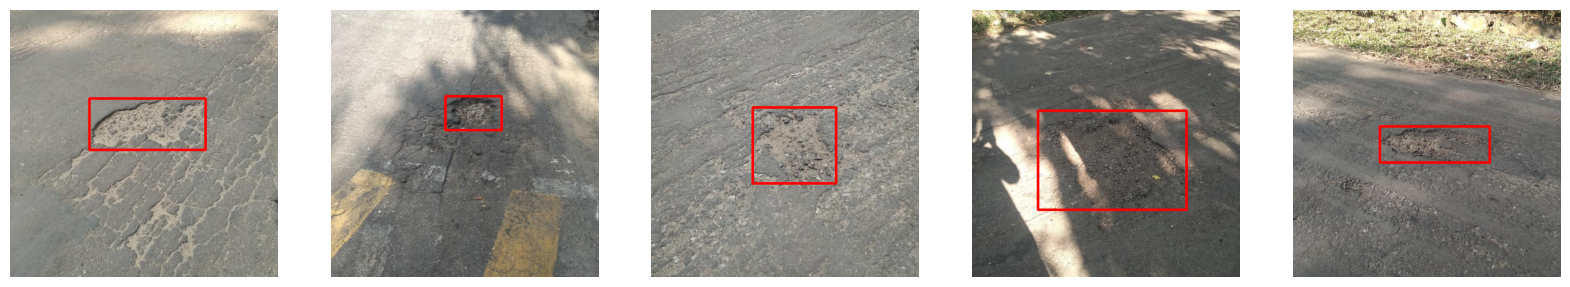

In [4]:
#Visiualizing the bounding boxes of the porvided dataset
num_of_image = 5
plt.figure(figsize=(20,20))
for test in range(num_of_image):
    test_bbox = bboxextractor(path2image = f"/kaggle/input/annotated-potholes-dataset/annotated-images/img-{test+1}.xml")
    plt.subplot(1, num_of_image , 1+test)
    test_image = plt.imread(f"/kaggle/input/annotated-potholes-dataset/annotated-images/img-{test+1}.jpg")
    cv.rectangle(test_image , (test_bbox[0],test_bbox[1]) , (test_bbox[2],test_bbox[3]) , 
                 color = (255 , 0 , 0),thickness = 6 )
    plt.axis("off")
    plt.imshow(test_image)

In [5]:
test_image = plt.imread("/kaggle/input/annotated-potholes-dataset/annotated-images/img-1.jpg")
test_image_resized = cv.resize(test_image , (800,800))

In [6]:
#Transforming to Tensor
ToTen = transforms.ToTensor()
test_image_ten = ToTen(test_image_resized).unsqueeze(0).to(device)
test_image_ten.shape

torch.Size([1, 3, 800, 800])

# 4 Feature extraction

## 4.1 Downloading pretrained models

In [7]:
#Using vgg16 for feature extraction
#Note - the models will not be used for any other purpose in this notebook except for demonstration purpose
vgg_model = torchvision.models.vgg16(pretrained = True).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 303MB/s]


In [8]:
#faster rcnn model
rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 46.9MB/s]


In [9]:
req_features = []
print("Rquired Feaures :")
for feature in list(vgg_model.features):
    test_image_ten = feature(test_image_ten)
    if test_image_ten.size()[2] < 800//16:
        break
    print(test_image_ten.shape)
    req_features.append(feature)
    out_channels = test_image_ten.size()[1]
    
print(f"out channels : {out_channels}")
print(f"len of the required feature : {len(req_features)}")

Rquired Feaures :
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
out channels : 512
len of the required feature : 30


In [10]:
vgg_extractor = nn.Sequential(*req_features)

In [11]:
test_image_ten2 = ToTen(test_image_resized).unsqueeze(0).to(device)
test_image_ten2.shape

torch.Size([1, 3, 800, 800])

In [12]:
test_extracted = vgg_extractor(test_image_ten2)
test_extracted

tensor([[[[1.5874, 2.1434, 1.5328,  ..., 1.4781, 2.0597, 2.1528],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3297, 0.9732],
          [0.0731, 0.3598, 0.0000,  ..., 0.0000, 0.7035, 1.5067],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0659, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 1.4849, 1.1939, 0.4890],
          [0.0000, 0.0000, 0.0000,  ..., 2.5429, 2.2965, 0.8706],
          [0.0000, 0.0000, 0.0229,  ..., 2.8693, 2.8339, 1.3387],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3711, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

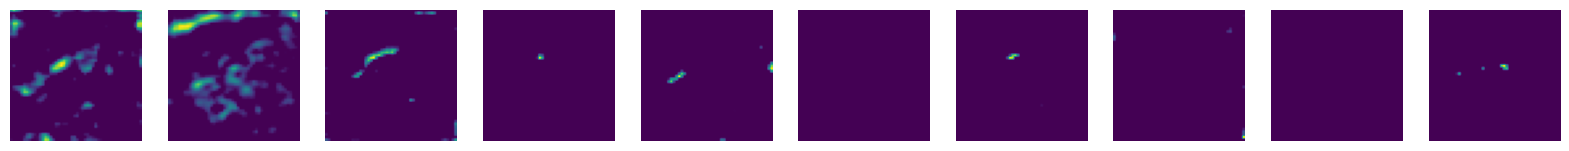

In [13]:
#10 out of 500
num_of_image = 10
plt.figure(figsize=(20,20))
for image in range(num_of_image):
    plt.subplot(1,num_of_image ,image+1)
    plt.imshow(test_extracted.data.numpy().squeeze(0)[image])
    plt.axis("off")

# 5 Model Visiualization using summary()

In [14]:
#Visiaulizing the models using summary()
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(vgg_extractor , input_size=[1, 3, 800, 800])


/opt/conda/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/conda/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 50, 50]          --
├─Conv2d: 1-1                            [1, 64, 800, 800]         1,792
├─ReLU: 1-2                              [1, 64, 800, 800]         --
├─Conv2d: 1-3                            [1, 64, 800, 800]         36,928
├─ReLU: 1-4                              [1, 64, 800, 800]         --
├─MaxPool2d: 1-5                         [1, 64, 400, 400]         --
├─Conv2d: 1-6                            [1, 128, 400, 400]        73,856
├─ReLU: 1-7                              [1, 128, 400, 400]        --
├─Conv2d: 1-8                            [1, 128, 400, 400]        147,584
├─ReLU: 1-9                              [1, 128, 400, 400]        --
├─MaxPool2d: 1-10                        [1, 128, 200, 200]        --
├─Conv2d: 1-11                           [1, 256, 200, 200]        295,168
├─ReLU: 1-12                             [1, 256, 200, 200]     

In [15]:
summary(rcnn_model , input_size=[1, 3, 800, 800])

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [0, 4]                    --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              


# 6 Preparing the anchor boxes

In [16]:
#anchor box grid - 50 x 50
fe_size = 800//16
ctr_x = np.arange(16 , (fe_size + 1)*16 , 16 )
ctr_y = np.arange(16 , (fe_size + 1)*16 , 16 )

print(len(ctr_x) , len(ctr_y))
print(ctr_x ,'\n', ctr_y)

50 50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800] 
 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [17]:
#Centers of the anchor boxes
index = 0
ctr = np.zeros((2500 , 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index , 1] = ctr_x[x] - 8
        ctr[index , 0] = ctr_y[y] - 8
        index += 1
ctr , ctr.shape

(array([[  8.,   8.],
        [ 24.,   8.],
        [ 40.,   8.],
        ...,
        [760., 792.],
        [776., 792.],
        [792., 792.]]),
 (2500, 2))

Text(0.5, 1.0, '25 x 25 anchor boxes centers depeicted by circles')

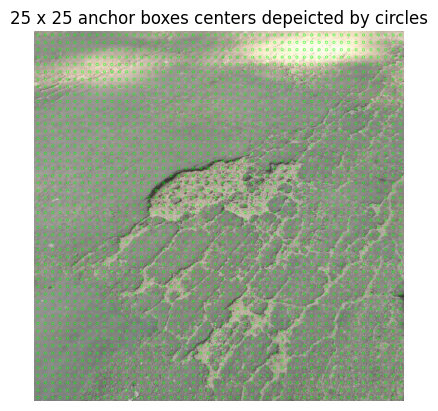

In [18]:
#Visualizing the anchor box centers
test_image_resized1 = np.copy(test_image_resized)

for cicle_itter in range(ctr.shape[0]):
    cv.circle(test_image_resized1 , (int(ctr[cicle_itter][0]) , int(ctr[cicle_itter][1]) ), 
              radius = 3 , color = (0,255,0) , thickness = 1)
    

plt.imshow(test_image_resized1)
plt.axis("off")
plt.title("25 x 25 anchor boxes centers depeicted by circles")

# 7 Making of anchor boxes based on various ratios and scales

In [19]:
#total number of anchor boxes - 50 x 50 x 9 = 22500
ratio = [0.5 , 1 , 2]
scale =  [8 , 16 , 32]
sub_sample = 16
index = 0
anchor_boxes = np.zeros( (fe_size*fe_size*9 , 4) )

for anchor_cord in ctr:
    ctr_x , ctr_y = anchor_cord[0] , anchor_cord[1]
    
    for i in range(len(ratio)):
        for j in range(len(scale)):
            height = sub_sample * scale[j] * np.sqrt(ratio[i])
            width = sub_sample * scale[j] * np.sqrt(1/ratio[i])
            anchor_boxes[index , 0] = ctr_y - height / 2
            anchor_boxes[index , 1] = ctr_x - width / 2
            anchor_boxes[index , 2] = ctr_y + height / 2
            anchor_boxes[index , 3] = ctr_x + width / 2
            index += 1
            
anchor_boxes

array([[ -37.254834  ,  -82.50966799,   53.254834  ,   98.50966799],
       [ -82.50966799, -173.01933598,   98.50966799,  189.01933598],
       [-173.01933598, -354.03867197,  189.01933598,  370.03867197],
       ...,
       [ 701.49033201,  746.745166  ,  882.50966799,  837.254834  ],
       [ 610.98066402,  701.49033201,  973.01933598,  882.50966799],
       [ 429.96132803,  610.98066402, 1154.03867197,  973.01933598]])

In [20]:
anchor_box_test_cord = anchor_boxes[1]

(-0.5, 799.5, 799.5, -0.5)

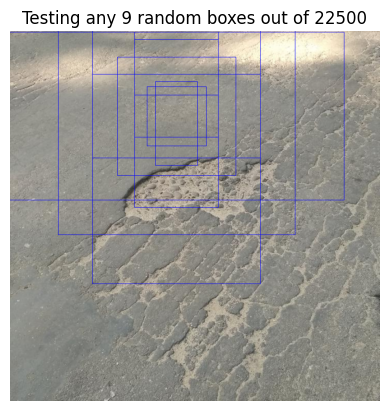

In [21]:
#9 anchor box at one center
test_image_resized2 = np.copy(test_image_resized)
for boxes in range(10000,10010):
    anchor_box_test_cord = anchor_boxes[boxes]
    cv.rectangle(test_image_resized2 , (int(anchor_box_test_cord[0]) , int(anchor_box_test_cord[1]) )  ,
                 (int(anchor_box_test_cord[2]) , int(anchor_box_test_cord[3]) ) , color = (0,0,255) , thickness = 1)
plt.imshow(test_image_resized2)
plt.title(f"Testing any 9 random boxes out of {len(anchor_boxes)}")
plt.axis("off")

# 8 Valid anchor box

In [22]:
anchor_boxes_valid_index = np.where( (anchor_boxes[:,0] >= 0) &
                                    (anchor_boxes[:,1] >= 0) &
                                    (anchor_boxes[:,2] <= 800) &
                                    (anchor_boxes[:,3] <= 800))[0]

valid_boxes = anchor_boxes[anchor_boxes_valid_index]
valid_boxes , valid_boxes.shape

(array([[ 10.745166  ,  13.49033201, 101.254834  , 194.50966799],
        [ 10.745166  ,  29.49033201, 101.254834  , 210.50966799],
        [ 10.745166  ,  45.49033201, 101.254834  , 226.50966799],
        ...,
        [698.745166  , 573.49033201, 789.254834  , 754.50966799],
        [698.745166  , 589.49033201, 789.254834  , 770.50966799],
        [698.745166  , 605.49033201, 789.254834  , 786.50966799]]),
 (8940, 4))

Text(0.5, 1.0, 'Testing any 100 random boxes out of 8940')

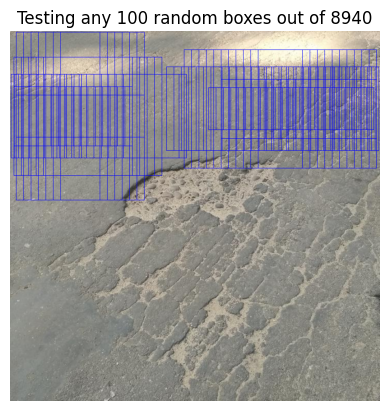

In [23]:
#Visualizing 100 anchor box
test_image_resized3 = np.copy(test_image_resized)

for boxes in range(1000 , 1100):
    anchor_box_test_cord = valid_boxes[boxes]
    cv.rectangle(test_image_resized3 , (int(anchor_box_test_cord[1]) , int(anchor_box_test_cord[0]) )  ,
                 (int(anchor_box_test_cord[3]) , int(anchor_box_test_cord[2]) ) , color = (0,0,255) , thickness = 1)
plt.imshow(test_image_resized3)
plt.axis("off")
plt.title(f"Testing any 100 random boxes out of {len(valid_boxes)}")

In [24]:
bbox = bboxextractor(path2image = f"/kaggle/input/annotated-potholes-dataset/annotated-images/img-1.xml")
bbox = [bbox]
bbox
"""bbox = np.array(bbox )"""

'bbox = np.array(bbox )'

# 9 IOU 

In [25]:
ious = np.empty((len(valid_boxes) , 2))
ious.fill(0)
num2 = 0

for num1 , i in enumerate(valid_boxes):
    ya1 , xa1 , ya2 , xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    
    
    for num2 , j in enumerate(bbox):
        yb1 , xb1 , yb2 , xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        
        inter_x1 = max([xb1 , xa1])
        inter_y1 = max([yb1 , ya1])
        inter_x2 = max([xb2 , xa2])
        inter_y2 = max([yb2 , ya2])

        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)

        else:
            iou = 0
        ious[num1 , num2] = iou

ious , ious.shape

(array([[2.62792969, 0.        ],
        [2.62792969, 0.        ],
        [2.62792969, 0.        ],
        ...,
        [0.38052768, 0.        ],
        [0.38052768, 0.        ],
        [0.38052768, 0.        ]]),
 (8940, 2))

In [26]:
#Getting the box with maximum iou
get_max_iou_index = ious.argmax(axis = 0)
print(get_max_iou_index)

get_max_iou = ious[get_max_iou_index , np.arange(ious.shape[1])]
print(get_max_iou)

gt_arg_max = np.where(ious == get_max_iou[0])[0]
print(gt_arg_max)

[3062    0]
[39.80477433  0.        ]
[3062]


In [27]:
argmax_ious = ious.argmax(axis = 1)
print(argmax_ious)
print(argmax_ious.shape)

max_ious = ious[np.arange(len(anchor_boxes_valid_index)) , argmax_ious ]
print(max_ious)
print(max_ious.shape)

[0 0 0 ... 0 0 0]
(8940,)
[2.62792969 2.62792969 2.62792969 ... 0.38052768 0.38052768 0.38052768]
(8940,)


# 10 Visualizing the anchor box of the mazimum iou

Box dimension : [221.49033201 226.98066402 402.50966799 589.01933598]


Text(0.5, 1.0, 'Max iou visualized : 275')

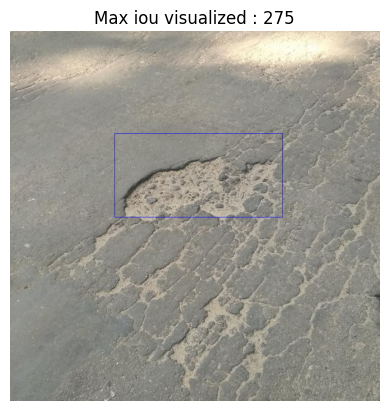

In [28]:
#Visualizing the box with maximum iou
test_image_resized4 = np.copy(test_image_resized)

test_valid_box_dimesion = valid_boxes[get_max_iou_index[0]]
print(f"Box dimension : {test_valid_box_dimesion}")

if len(test_valid_box_dimesion) == 4:
    test_valid_box_dimesion = [test_valid_box_dimesion]

for box in test_valid_box_dimesion:
    cv.rectangle(test_image_resized4 , (int(box[1]) , int(box[0]) )  ,
                     (int(box[3]) , int(box[2]) ) , color = (0,0,255) , thickness = 1)
    
plt.imshow(test_image_resized4)
plt.axis("off")
plt.title(f"Max iou visualized : {np.argmax(argmax_ious)}")

Text(0.5, 1.0, 'Selection of anchor box with the largest iou : 275')

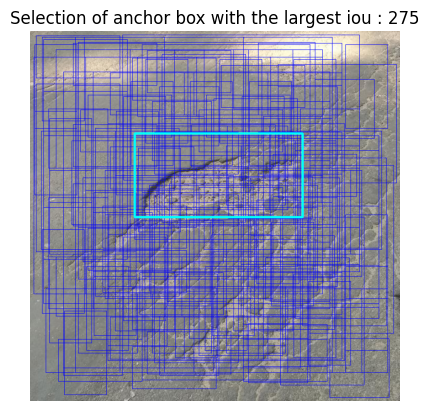

In [29]:
#Anchor box selection from the rest
test_image_resized5 = np.copy(test_image_resized)
simplicity_skip = 50

for boxes in range(0 , len(valid_boxes) , simplicity_skip):
    anchor_box_test_cord = valid_boxes[boxes]
    cv.rectangle(test_image_resized5 , (int(anchor_box_test_cord[1]) , int(anchor_box_test_cord[0]) )  ,
                 (int(anchor_box_test_cord[3]) , int(anchor_box_test_cord[2]) ) , color = (0,0,255) , thickness = 1)
    
    cv.rectangle(test_image_resized5 , (int(box[1]) , int(box[0]) )  ,
                     (int(box[3]) , int(box[2]) ) , color = (0,255,255) , thickness = 3)
plt.imshow(test_image_resized5)
plt.axis("off")
plt.title(f"Selection of anchor box with the largest iou : {np.argmax(argmax_ious)}")

Box dimension : [221.49033201 226.98066402 402.50966799 589.01933598]


Text(0.5, 1.0, 'Anchor box vs Annotation')

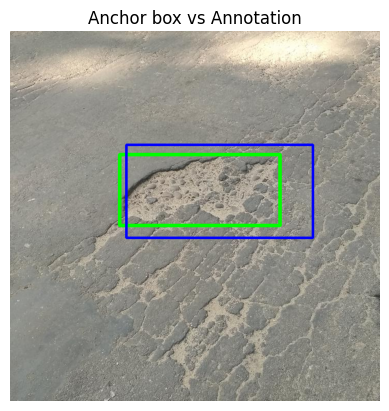

In [30]:
#Comparision
test_image_resized6 = np.copy(test_image)
true_bbox = bboxextractor(path2image = f"/kaggle/input/annotated-potholes-dataset/annotated-images/img-1.xml")
cv.rectangle(test_image_resized6 , (true_bbox[0] , true_bbox[1] )  ,
                     (true_bbox[2] , true_bbox[3] ) , color = (0,255,0) , thickness = 5 )



cv.resize(test_image_resized6 , (800,800))

test_valid_box_dimesion = valid_boxes[get_max_iou_index[0]]
print(f"Box dimension : {test_valid_box_dimesion}")

if len(test_valid_box_dimesion) == 4:
    test_valid_box_dimesion = [test_valid_box_dimesion]

for box in test_valid_box_dimesion:
    cv.rectangle(test_image_resized6 , (int(box[1]) , int(box[0]) )  ,
                     (int(box[3]) , int(box[2]) ) , color = (0,0,255) , thickness = 3)

    
plt.imshow(test_image_resized6)
plt.axis("off")
plt.title(f"Anchor box vs Annotation")